In [1]:
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import scFates as scf
sc.set_figure_params(dpi=150)

In [2]:
adata=sc.read("data/adata_processed.h5ad")

In [3]:
adata=adata[~adata.obs.leiden.isin(["0","21","25"])]

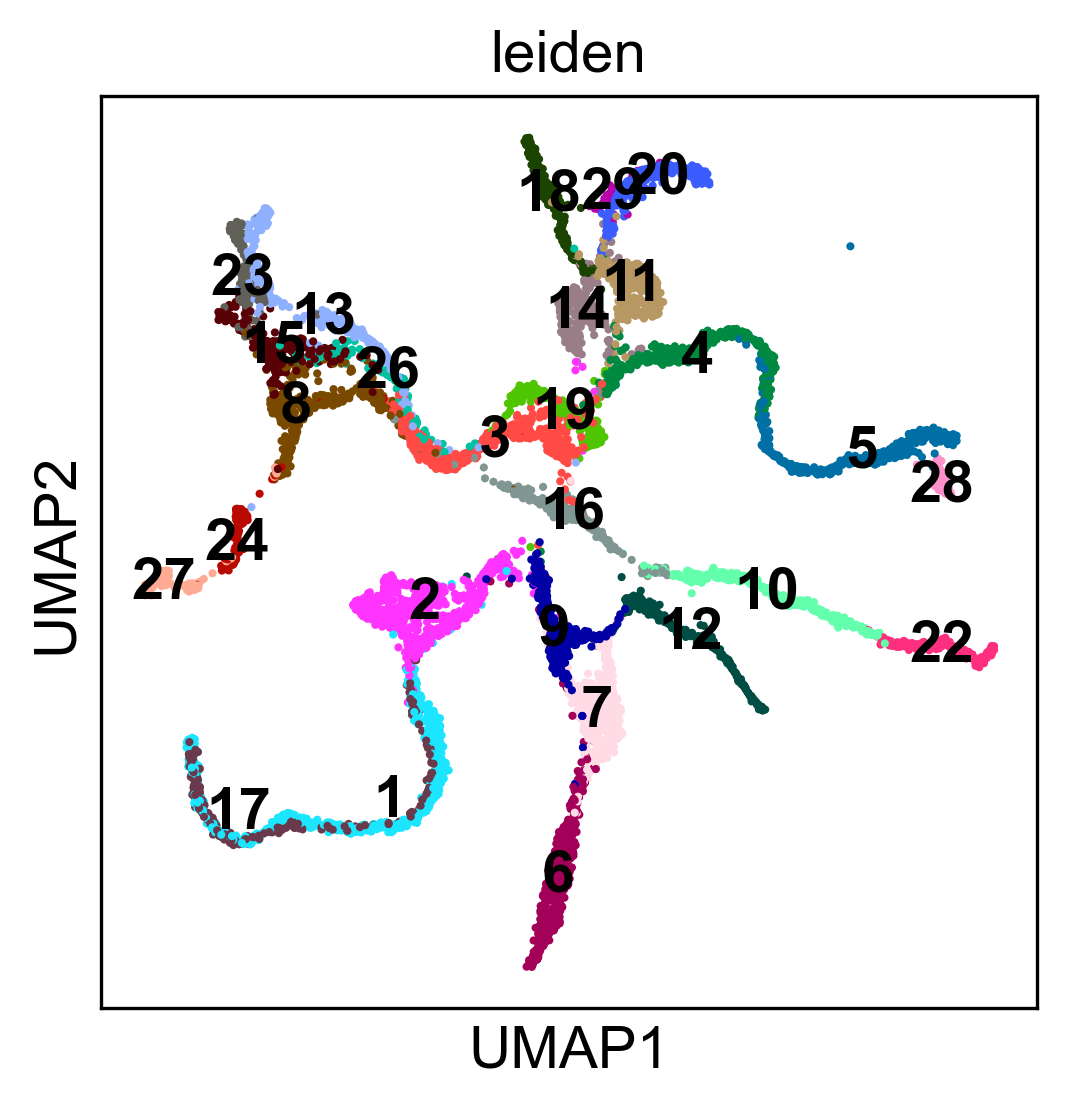

In [4]:
sc.pl.umap(adata,color="leiden",legend_loc="on data")

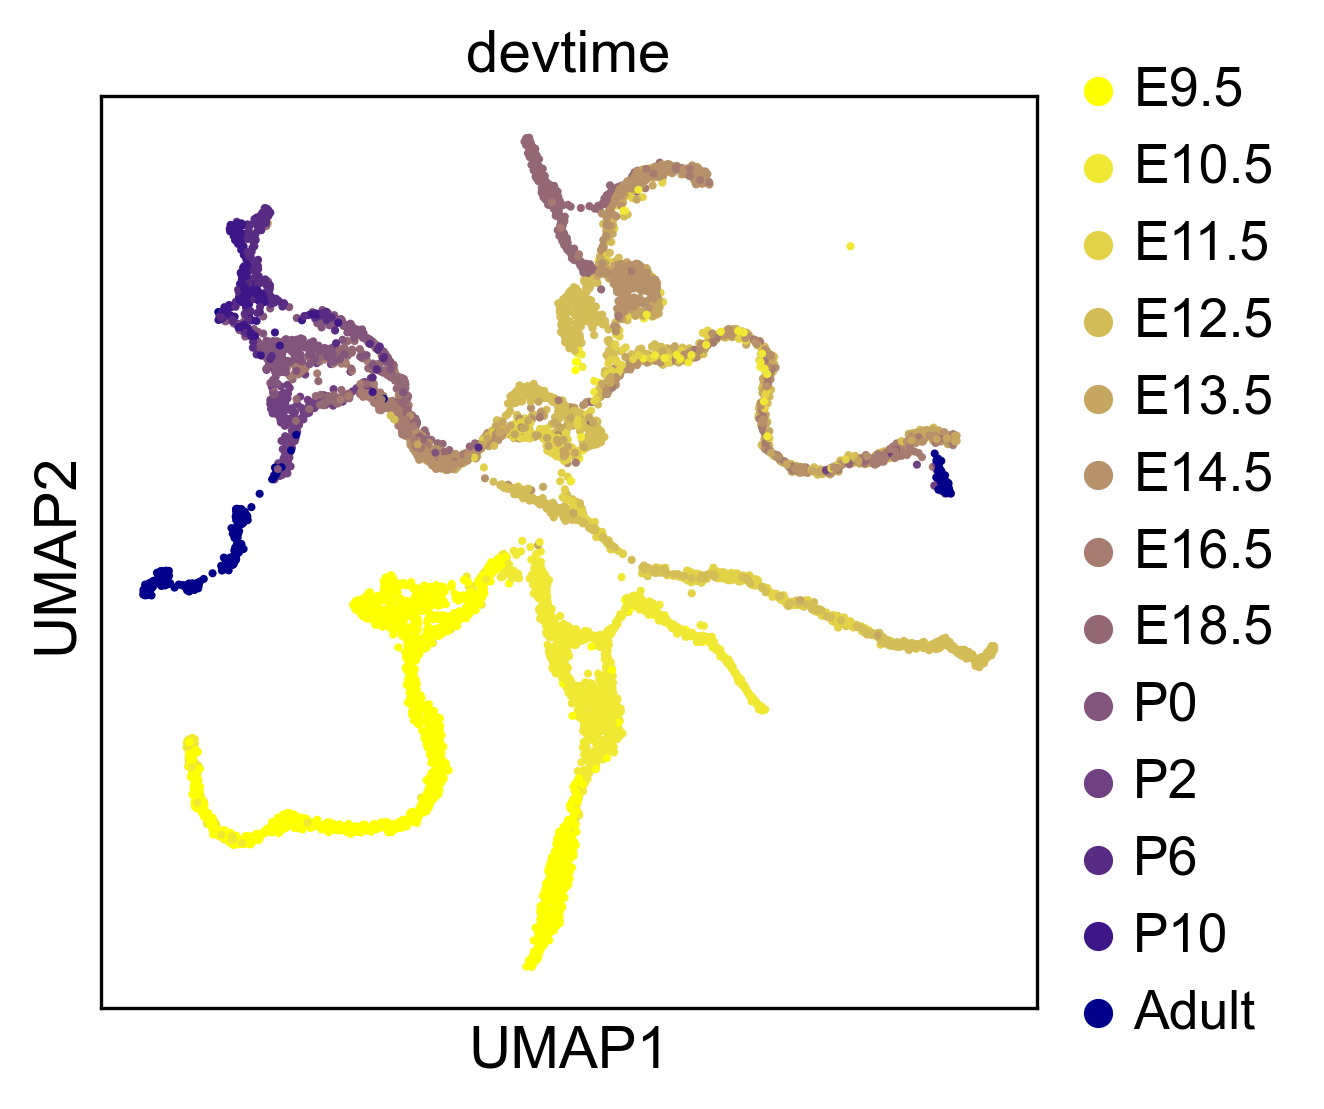

In [5]:
sc.pl.umap(adata,color="devtime")

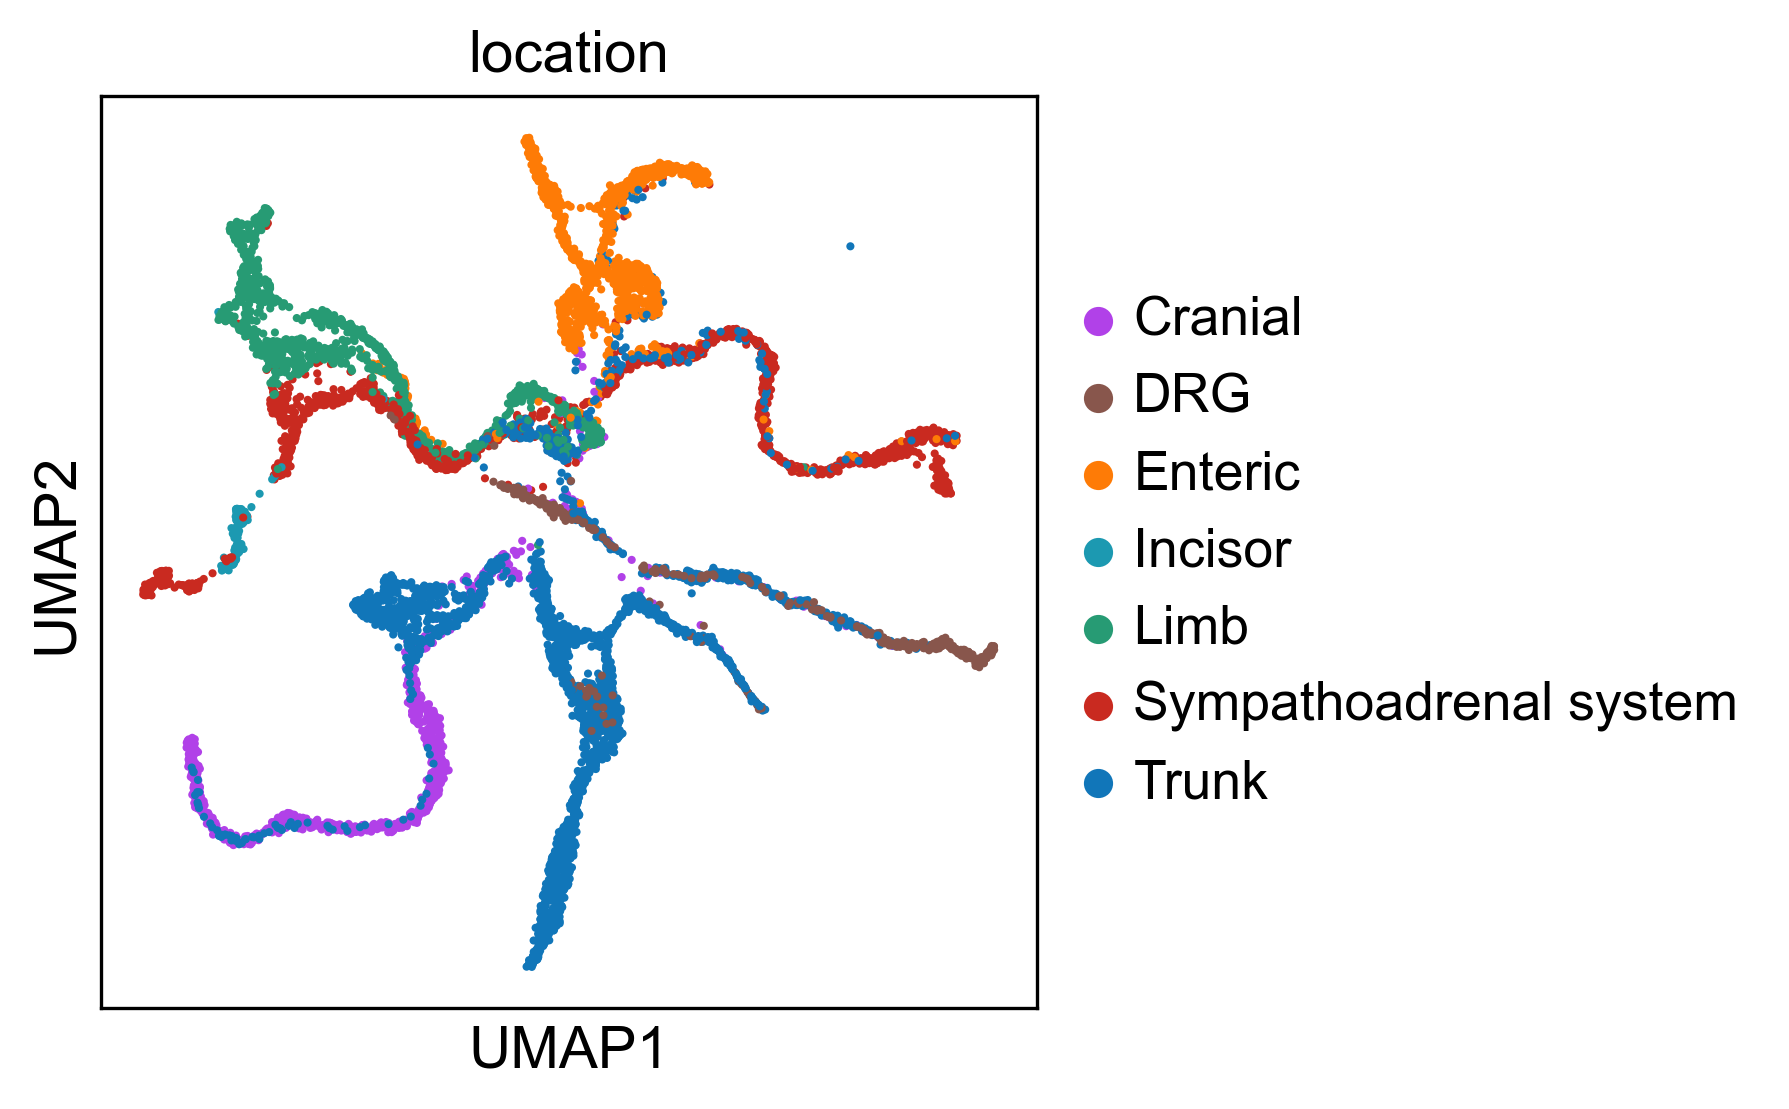

In [6]:
sc.pl.umap(adata,color="location")

In [7]:
scf.tl.tree(adata,Nodes=3000,method="ppt",device="gpu",seed=100,
            use_rep="X_diff",ppt_sigma=.0005,ppt_lambda=200,ppt_nsteps=100)

inferring a principal tree inferring a principal tree --> parameters used 
    3000 principal points, sigma = 0.0005, lambda = 200, metric = euclidean
    fitting:  63%|██████▎   | 63/100 [00:24<00:14,  2.52it/s]
    converged


Trying to set attribute `.uns` of view, copying.


    finished (0:00:30) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


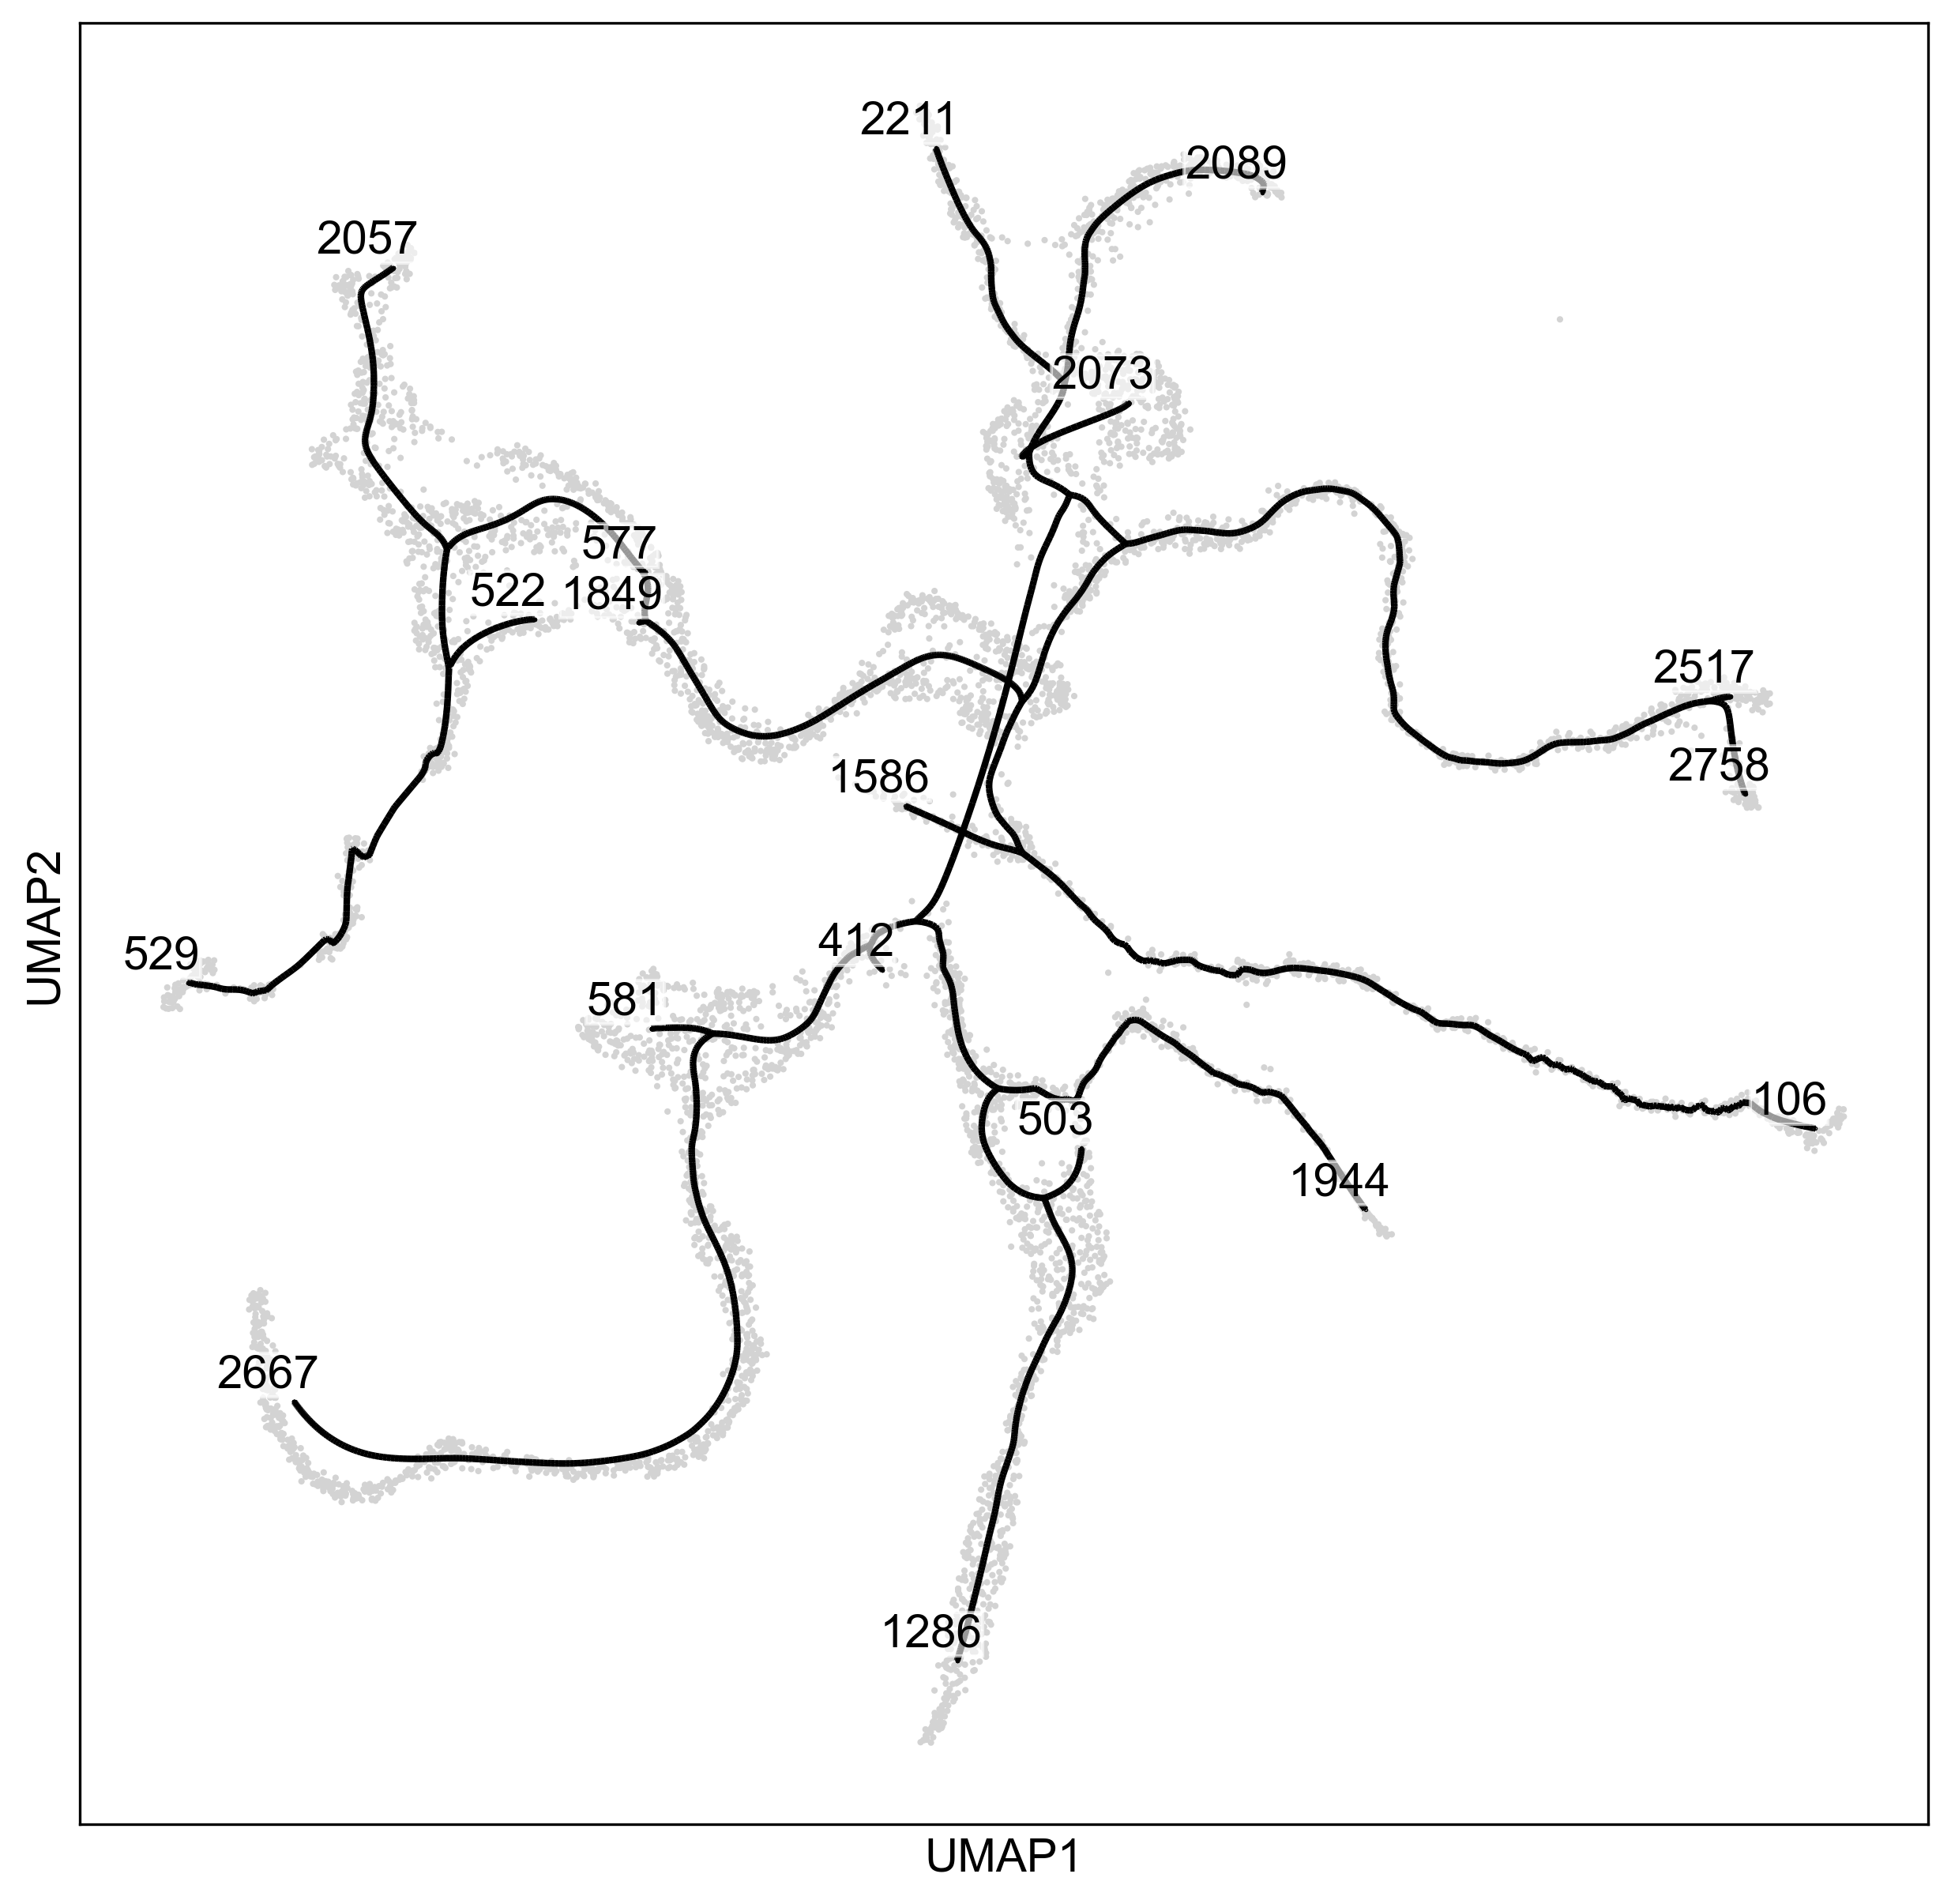

In [8]:
sc.set_figure_params(dpi=150,figsize=(10,10))
scf.pl.graph(adata,size_nodes=.1,forks=False)

In [9]:
import igraph
import pandas as pd
B = adata.uns["graph"]["B"]
tips = adata.uns["graph"]["tips"]
torem = []
g = igraph.Graph.Adjacency((B > 0).tolist(), mode="undirected")
tips = np.argwhere(np.array(g.degree()) == 1).flatten()
branches = np.argwhere(np.array(g.degree()) > 2).flatten()


dist = np.array(
    list(
        map(
            lambda t: np.min(
                list(map(len, g.get_all_shortest_paths(t, branches)))
            ),
            tips,
        )
    )
)

pd.Series(dist,index=tips)

106     271
412      21
503      23
522      29
529     169
577      12
581      64
1286    224
1586     25
1849     11
1944    176
2057    143
2073     98
2089    123
2211    106
2517     16
2667    331
2758     29
dtype: int64

In [9]:
scf.tl.cleanup(adata,minbranchlength=24,leaves=[522,2073])

    graph cleaned --> removed 203 principal points


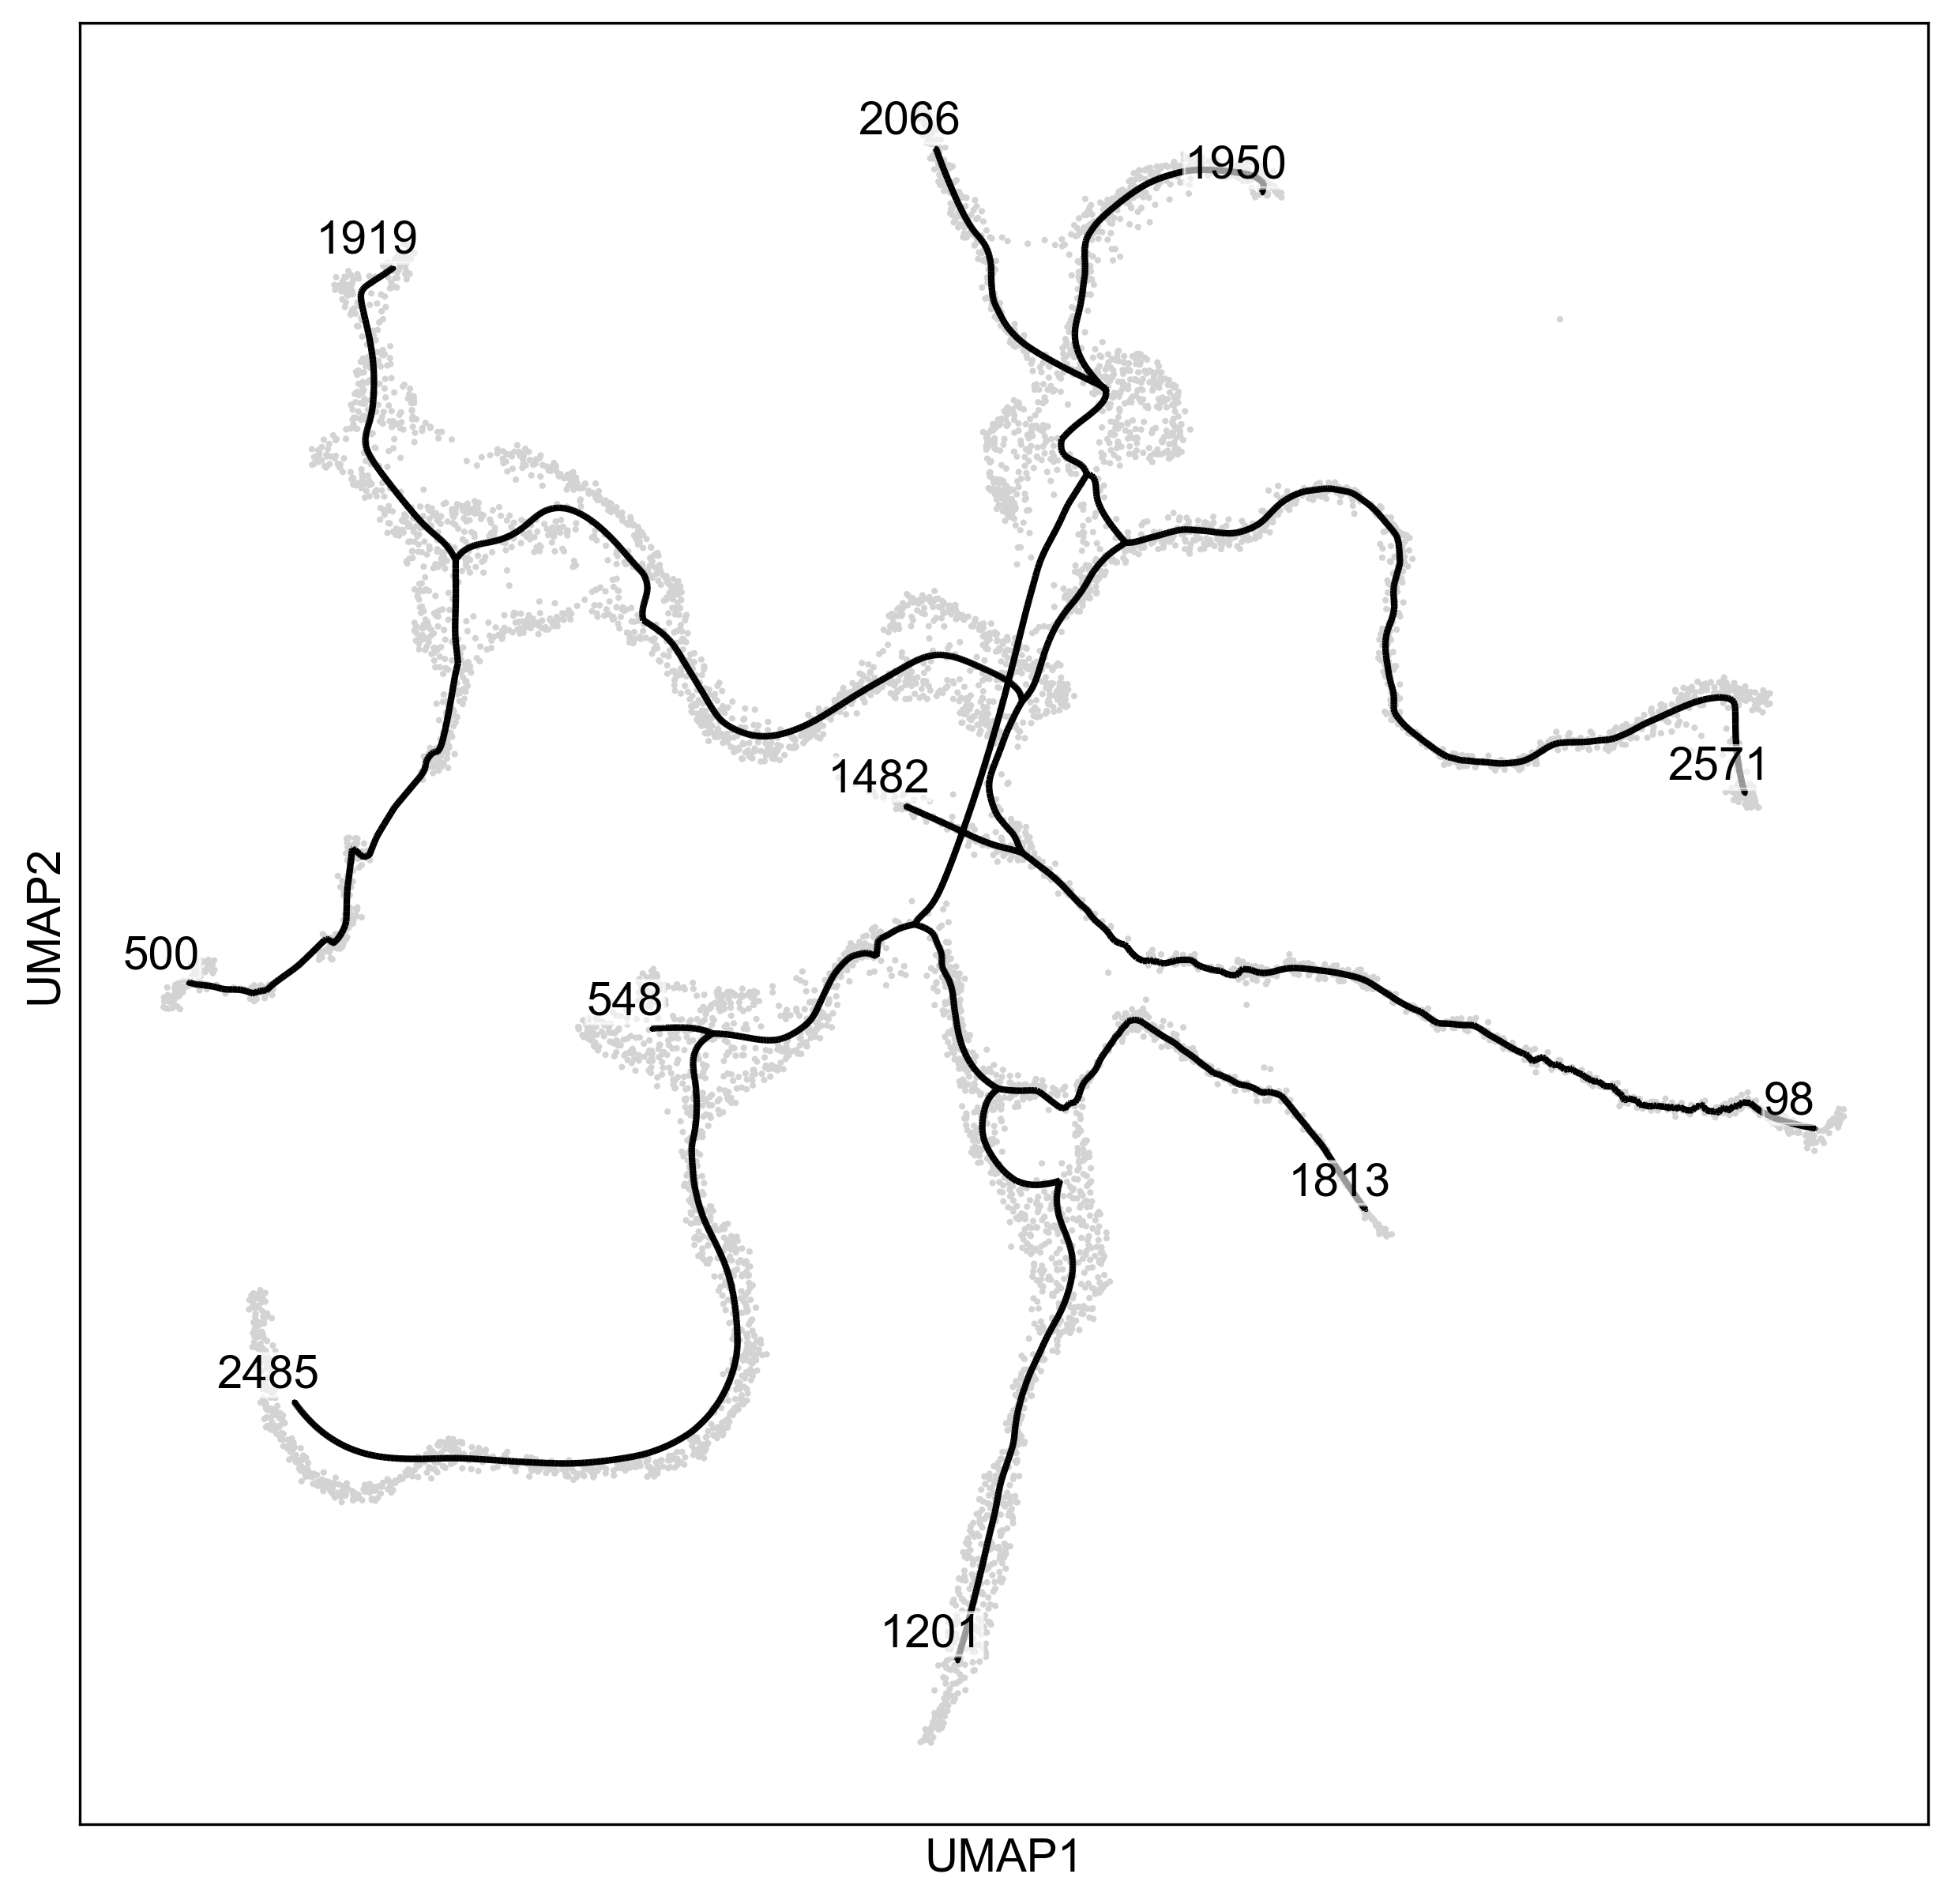

In [10]:
scf.pl.graph(adata,size_nodes=.1,forks=False)

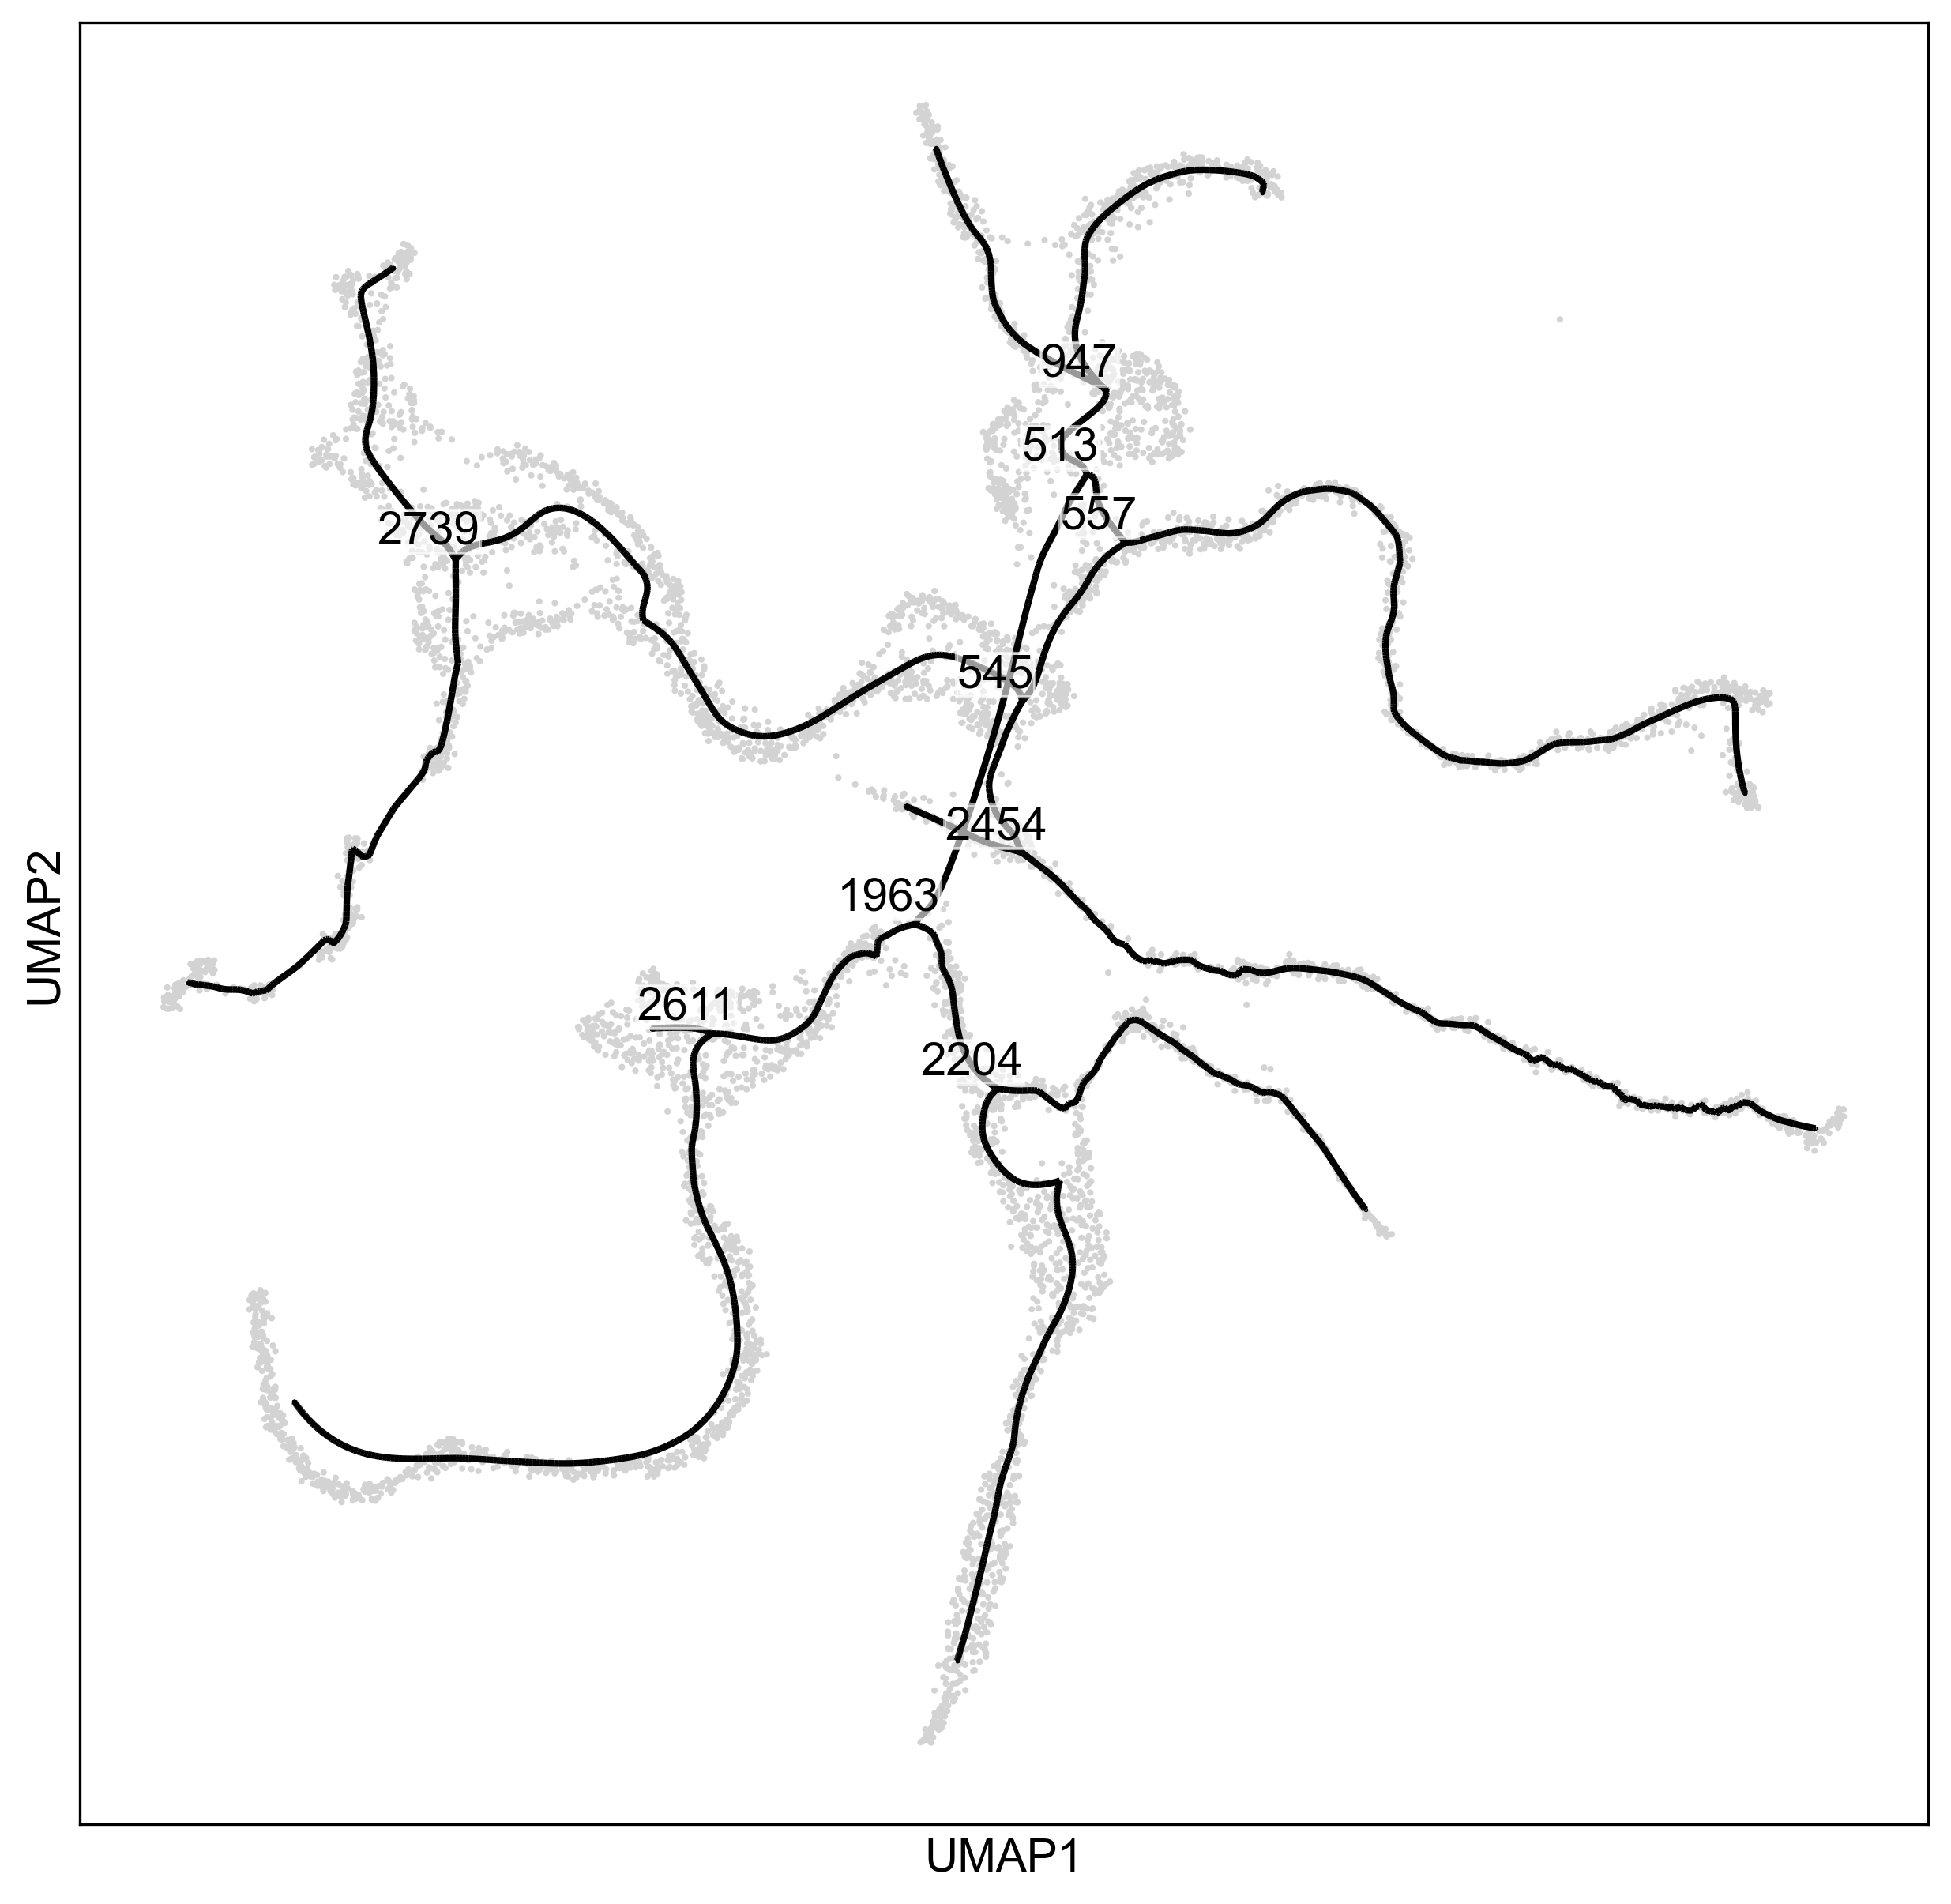

In [11]:
sc.set_figure_params(dpi=150,figsize=(10,10))
scf.pl.graph(adata,size_nodes=.1,tips=False)

In [12]:
scf.tl.roots(adata,[548,1201],1963)

root selected --> added
    1201 is the farthest root.
    .uns['graph']['root'] farthest root selected.
    .uns['graph']['root2'] 2nd root selected.
    .uns['graph']['meeting'] meeting point on the tree.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [13]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:11) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


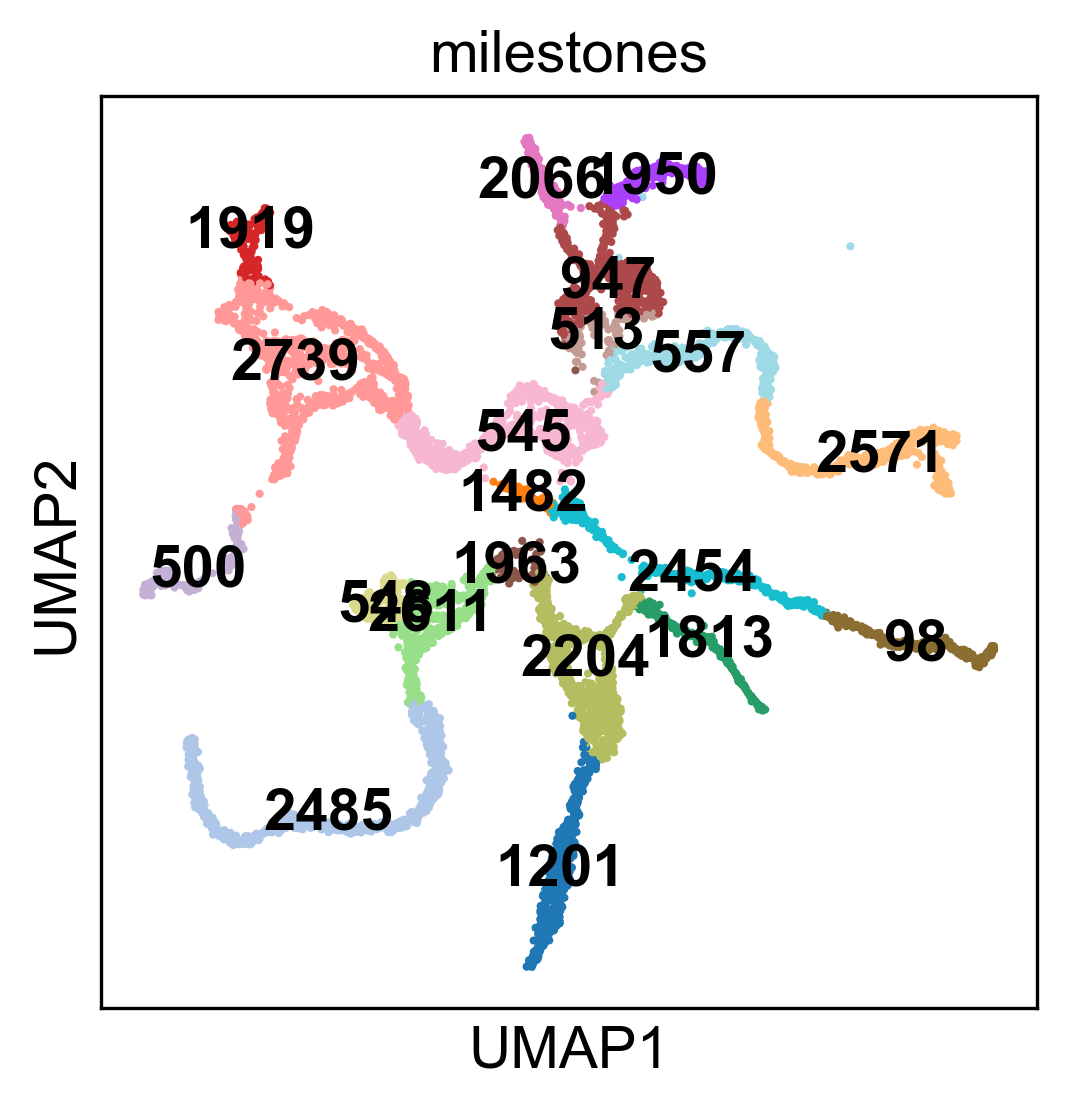

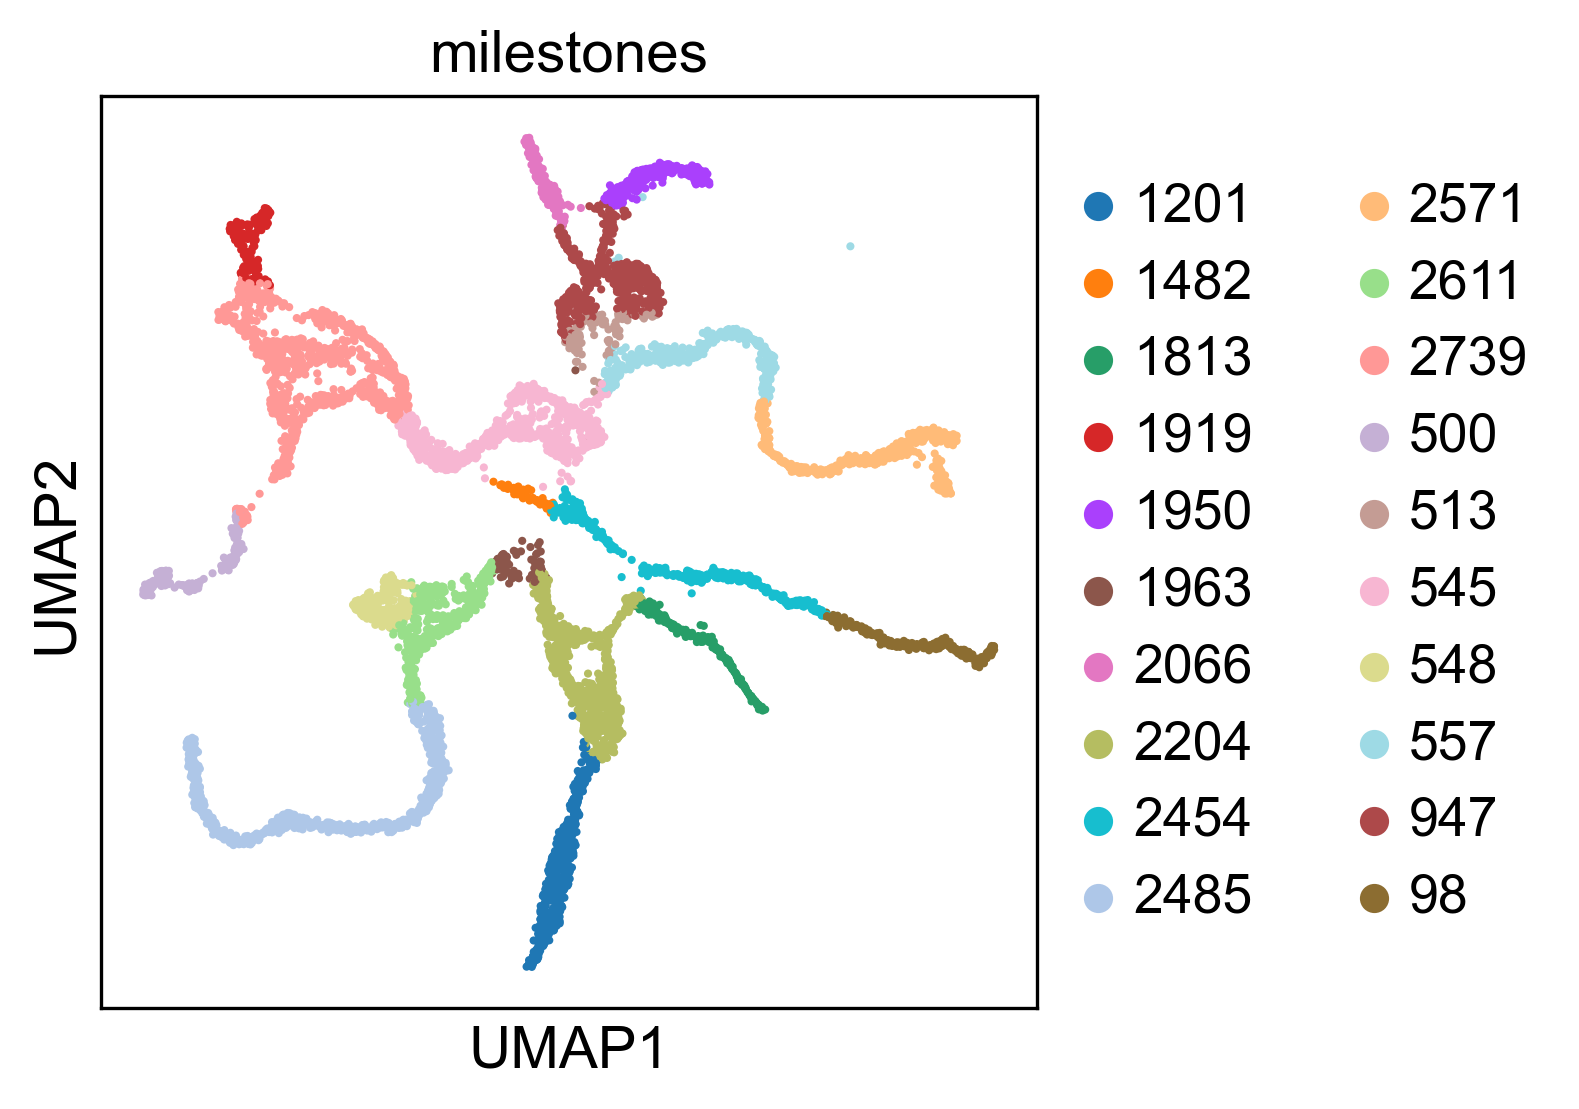

In [14]:
sc.set_figure_params(dpi=150)
sc.pl.umap(adata,color="milestones",legend_loc="on data")
sc.pl.umap(adata,color="milestones")

In [15]:
assign={"98":"Sensory 2",
        "2611":"NCC1<>Mesenchyme",
        "2739":"mSC<>enFib",
        "1201":"NCC2",
        "500":"nmSC",
        "2571":"ChC",
        "2454":"Sensory 2<>SatGlia",
        "1950":"GutNeuron",
        "513":"Hub",
        "2485":"Mesenchyme",
        "545":"SCP-Hub",
        "947":"GutGlia<>GutNeuron",
        "2204":"Sensory 1<>Hub",
        "557":"Hub-Adrenal",
        "1813":"Sensory 1",
        "1919":"enFib",
        "2066":"GutGlia",
        "1482":"SatGlia",
        "548":"NCC1",
        "1963":"Convergence"}

In [16]:
scf.tl.rename_milestones(adata,[assign[m] for m in adata.obs.milestones.cat.categories])

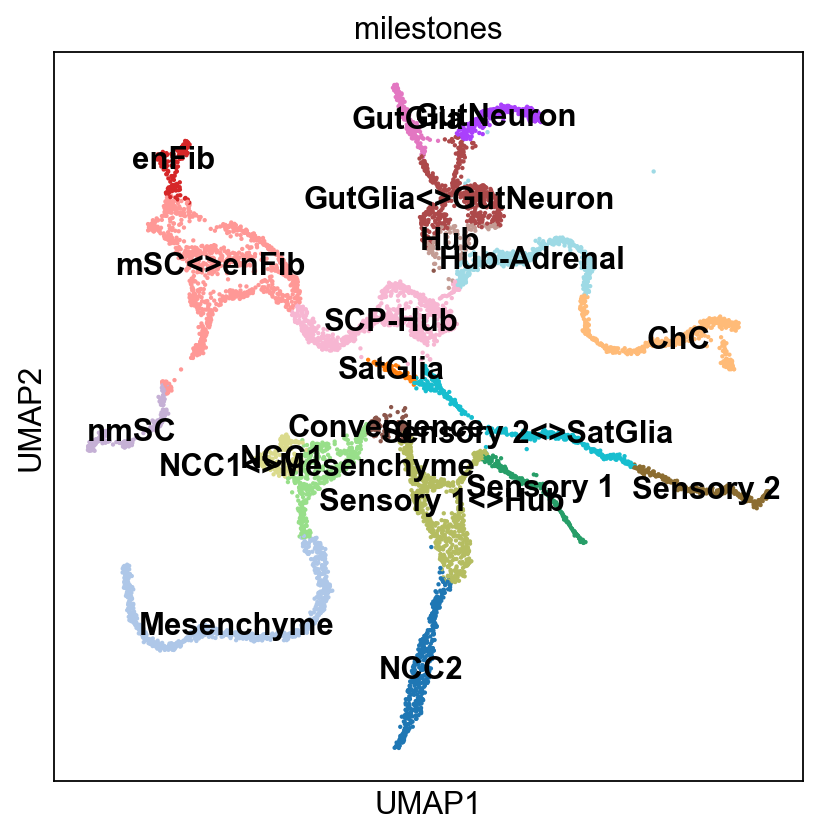

In [17]:
sc.set_figure_params(figsize=(6,6))
sc.pl.umap(adata,color="milestones",legend_loc="on data")

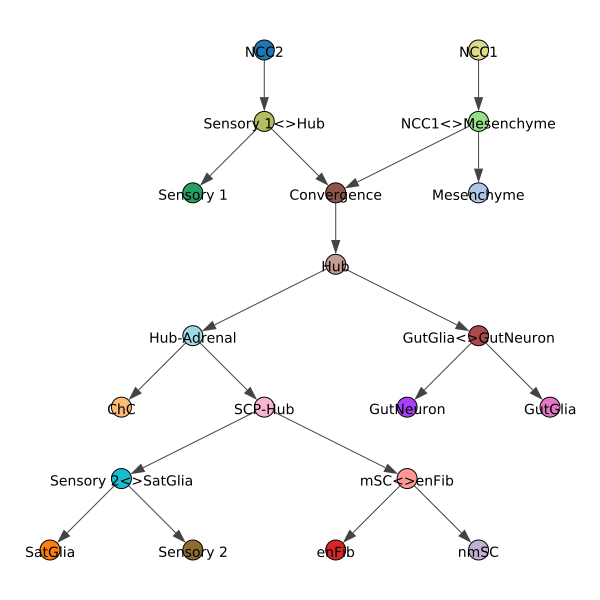

In [18]:
scf.pl.milestones(adata,roots=["NCC1","NCC2"],layout="reingold_manifold",figsize=(600,600))

In [19]:
adata_glia=scf.tl.subset_tree(adata,root_milestone="SCP-Hub",milestones=["nmSC","enFib"],copy=True)

subsetting tree
node 354 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:02) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.
    finished (0:00:00) --> tree extracted
--> added 
    .obs['old_milestones'], previous milestones from intial tree


In [20]:
adata_velo=sc.read("data/adata_velo.h5ad")

In [21]:
idx = (np.min(adata_velo.varm['fdr'], axis=1) < 1e-40)
gene_use = adata_velo.var.index[idx]
adata_velo=adata_velo[:,gene_use]

In [22]:
adata_velo=adata_velo[adata_glia.obs_names]
adata_velo.obs.leiden=adata_glia.obs.leiden

Trying to set attribute `.obs` of view, copying.


In [23]:
import scvelo as scv

computing neighbors
    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/2098 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


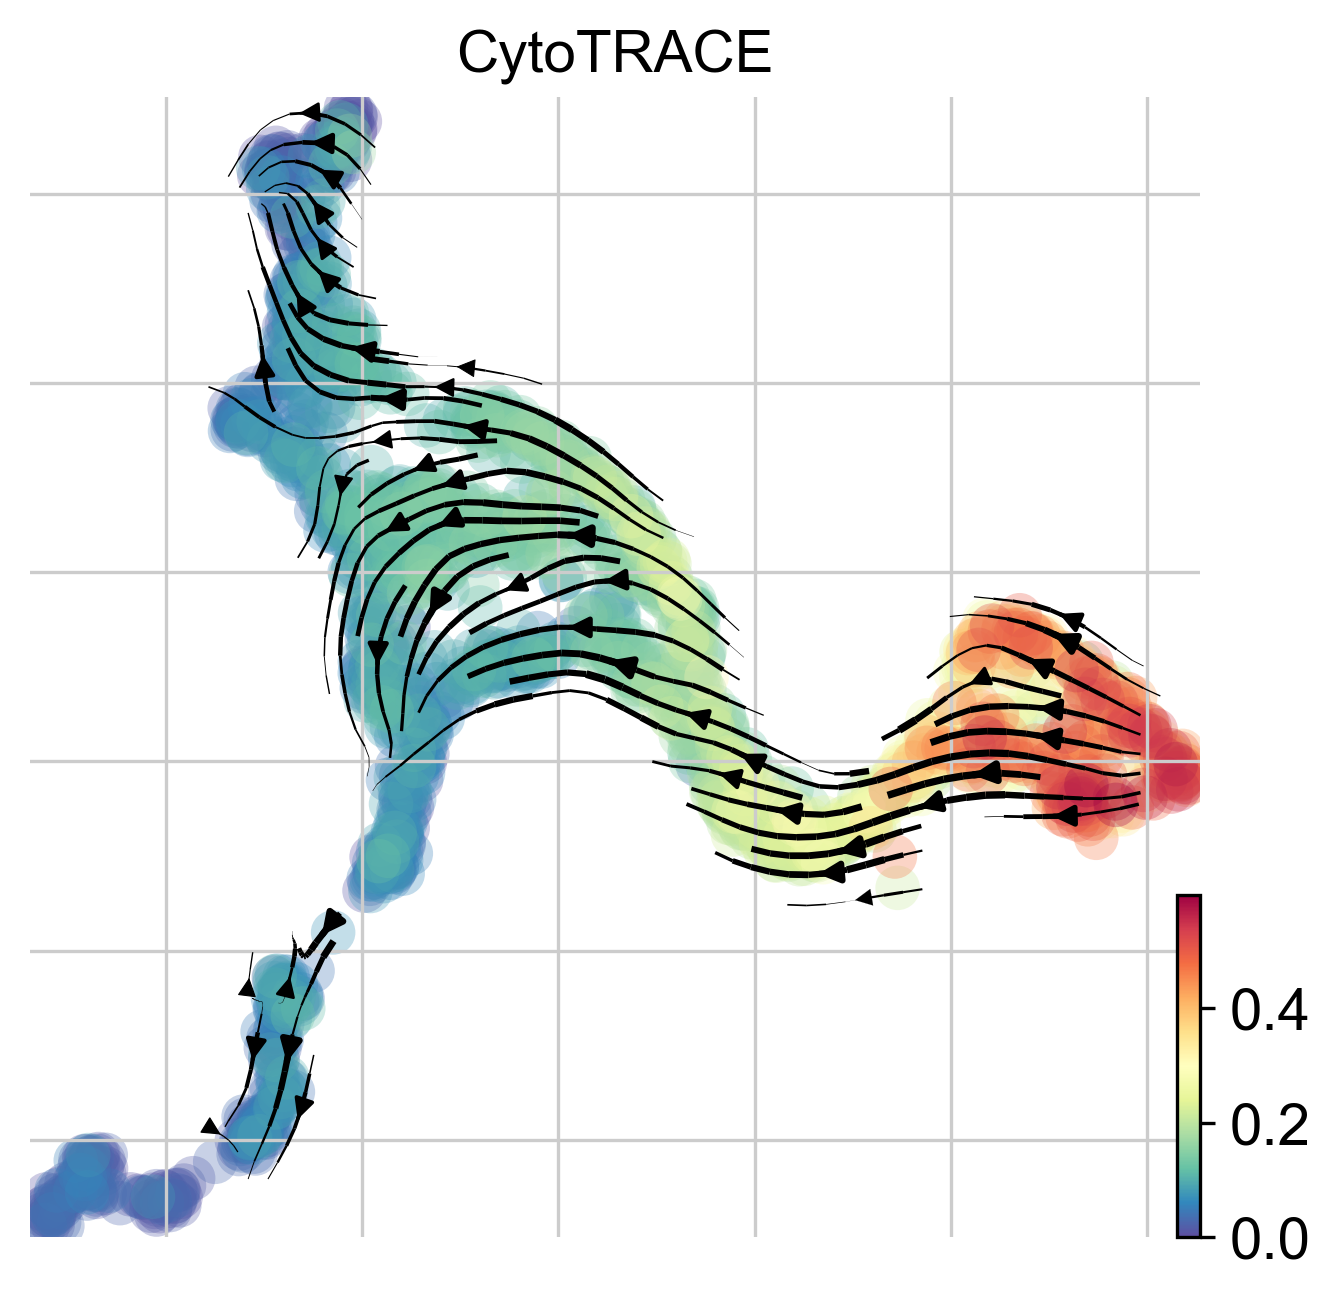

In [24]:
scv.pp.neighbors(adata_velo)
scv.pp.moments(adata_velo)
scv.tl.velocity_graph(adata_velo, gene_subset=gene_use)
scv.pl.velocity_embedding_stream(adata_velo, basis='umap',color="CytoTRACE",cmap="Spectral_r",figsize=(5,5),dpi=150)

In [25]:
import cellrank  as cr
from cellrank.tl.estimators import GPCCA
weight_connectivities=0.2
mode="stochastic"
n_jobs=80
softmax_scale=None

kernel = cr.tl.transition_matrix(adata_velo,
                                 weight_connectivities=weight_connectivities,
                                 mode=mode,
                                 n_jobs=n_jobs,seed=1,
                                 softmax_scale=softmax_scale)
g_fwd = GPCCA(kernel)
g_fwd.compute_schur(n_components=10)


Defaulting to `mode='monte_carlo'` and `n_samples=1000`


<ipython-input-25-d4aa528a4311>:8: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = cr.tl.transition_matrix(adata_velo,


  0%|          | 0/2098 [00:00<?, ?cell/s]

  0%|          | 0/2098 [00:00<?, ?sample/s]

In [26]:
n_states = 7
g_fwd.compute_macrostates(cluster_key='leiden', n_states=n_states)

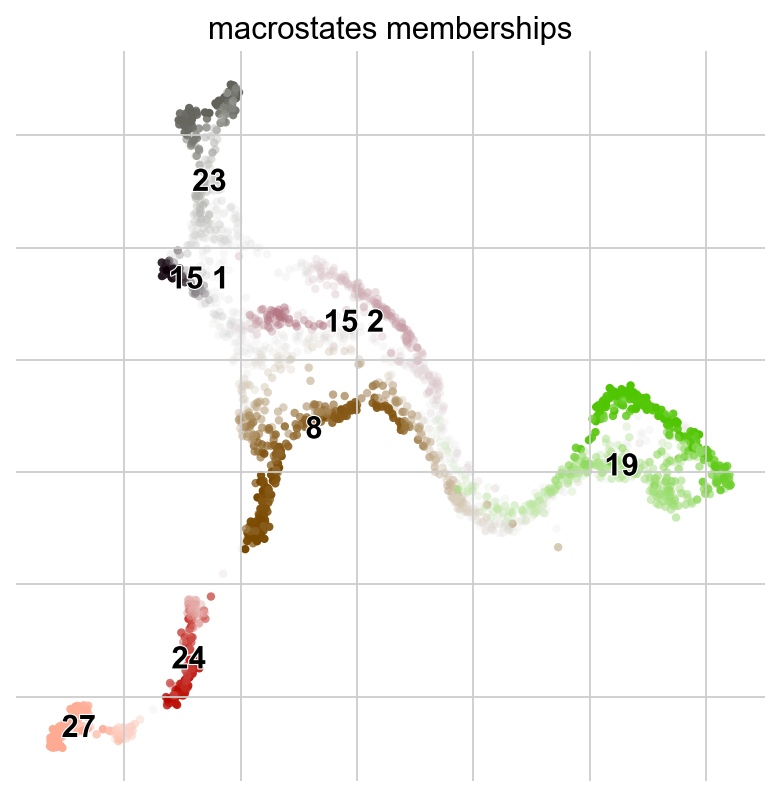

In [27]:
g_fwd.plot_macrostates()

Defaulting to `'gmres'` solver.


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/3 [00:00<?, ?/s]

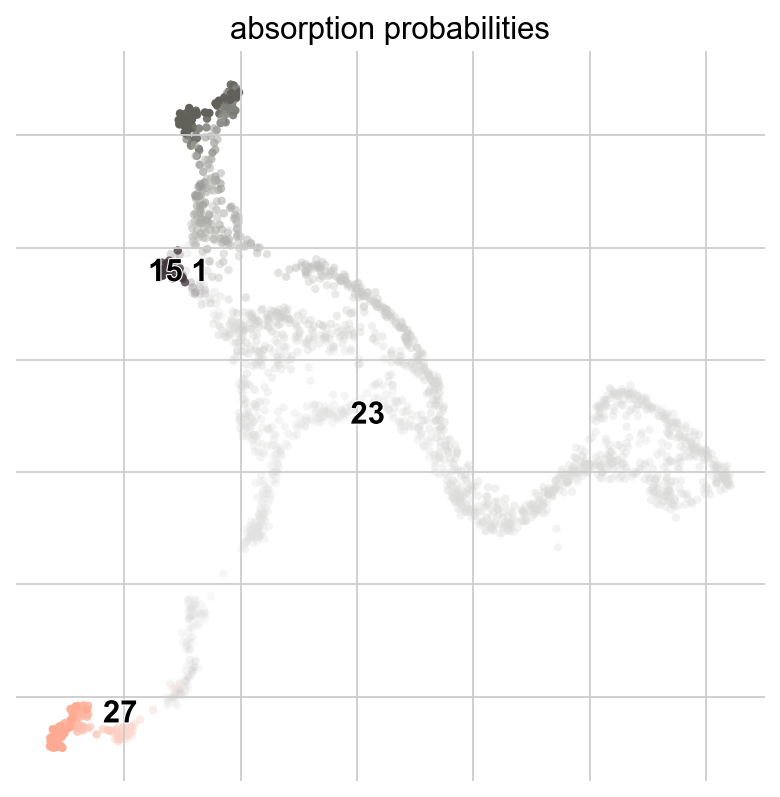

In [28]:
g_fwd.set_terminal_states_from_macrostates(names=['23','15_1','27'])
g_fwd.compute_absorption_probabilities()
cr.pl.lineages(adata_velo)

In [29]:
scf.tl.cellrank_to_tree(adata_velo,time="CytoTRACE",Nodes=300,seed=1,ppt_lambda=200,ppt_sigma=.05,auto_root=False,reassign_pseudotime=False)

Converting CellRank results to a principal tree --> with .obsm['X_fates'], created by combining:
    .obsm['X_fate_simplex_fwd'] (from cr.pl.circular_projection) and adata.obs['CytoTRACE']

inferring a principal tree inferring a principal tree --> parameters used 
    300 principal points, sigma = 0.05, lambda = 200, metric = euclidean
    fitting:   0%|          | 0/50 [00:00<?, ?it/s]

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    fitting:  96%|█████████▌| 48/50 [00:01<00:00, 24.08it/s]
    converged
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.

finished (0:00:02)     .obsm['X_fates'] representation used for fitting the tree.
    .uns['graph']['pp_info'].time has been updated with CytoTRACE
    .uns['graph']['pp_seg'].d has been updated with CytoTRACE


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


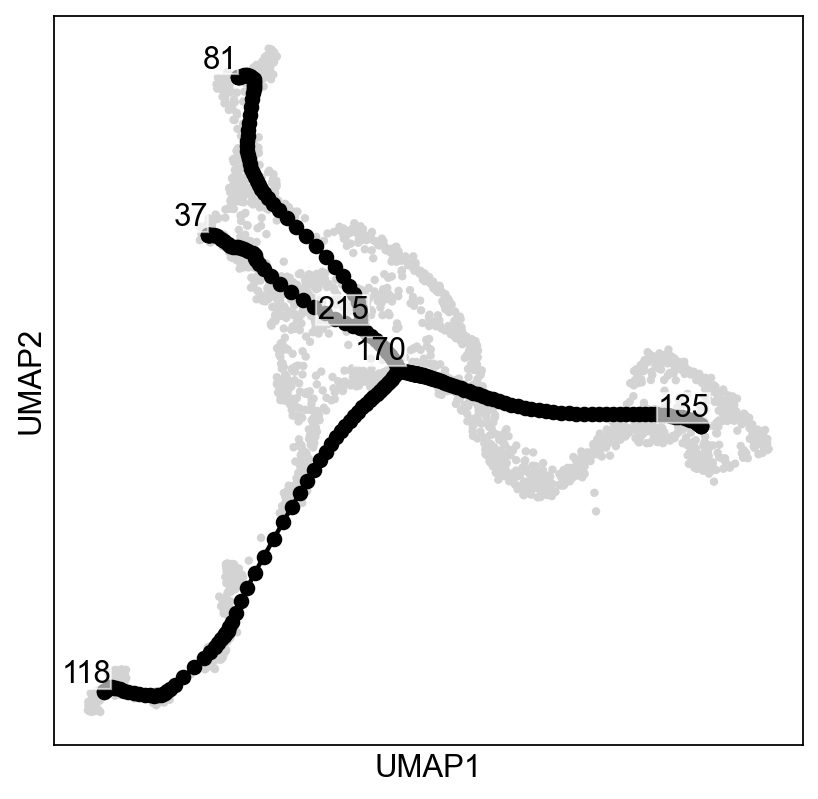

In [30]:
scf.pl.graph(adata_velo)

subsetting tree
node 886 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph


/home/lfaure/scFates/scFates/tools/pseudotime.py:120: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  milestones = pd.Series(index=adata.obs_names)


    finished (0:00:08) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.
    finished (0:00:00) --> tree subsetted
--> added 
    .obs['old_milestones'], previous milestones from intial tree


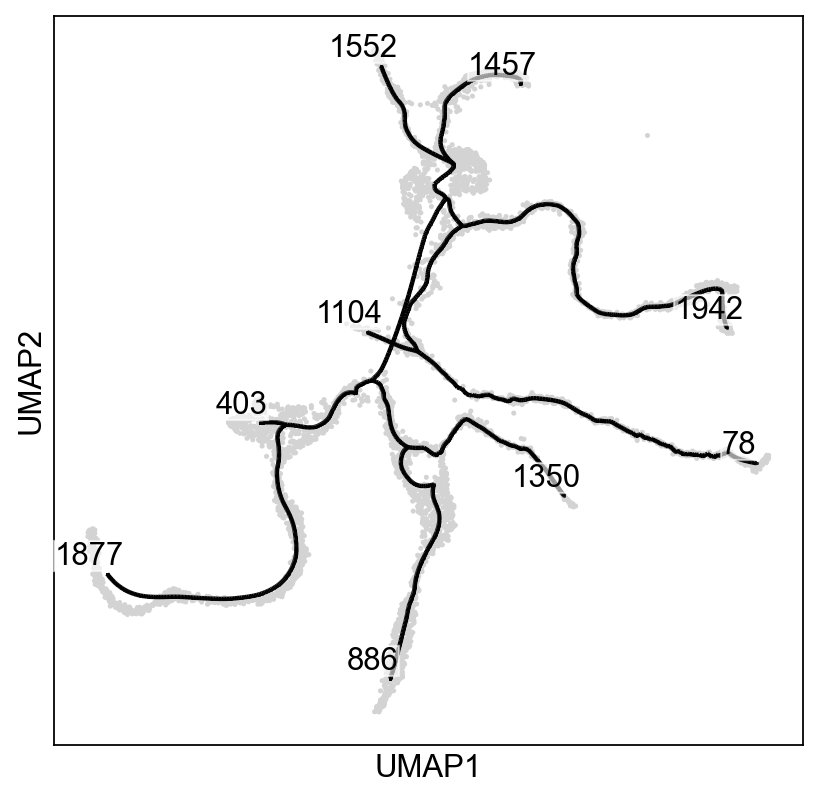

In [31]:
adata_rest=scf.tl.subset_tree(adata,root_milestone="SCP-Hub",milestones=["nmSC","enFib"],mode="substract",copy=True)

scf.pl.graph(adata_rest,size_nodes=.1,forks=False)

In [32]:
adata_merged=scf.tl.attach_tree(adata_rest,adata_velo,)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


attaching tree
    merging
    tree refitting
    finished (0:00:13) --> datasets combined


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    graph cleaned --> removed 1 principal points


... storing 'plates' as categorical
... storing 'devtime' as categorical
... storing 'location' as categorical
... storing 'leiden' as categorical
... storing 'Accession-1' as categorical


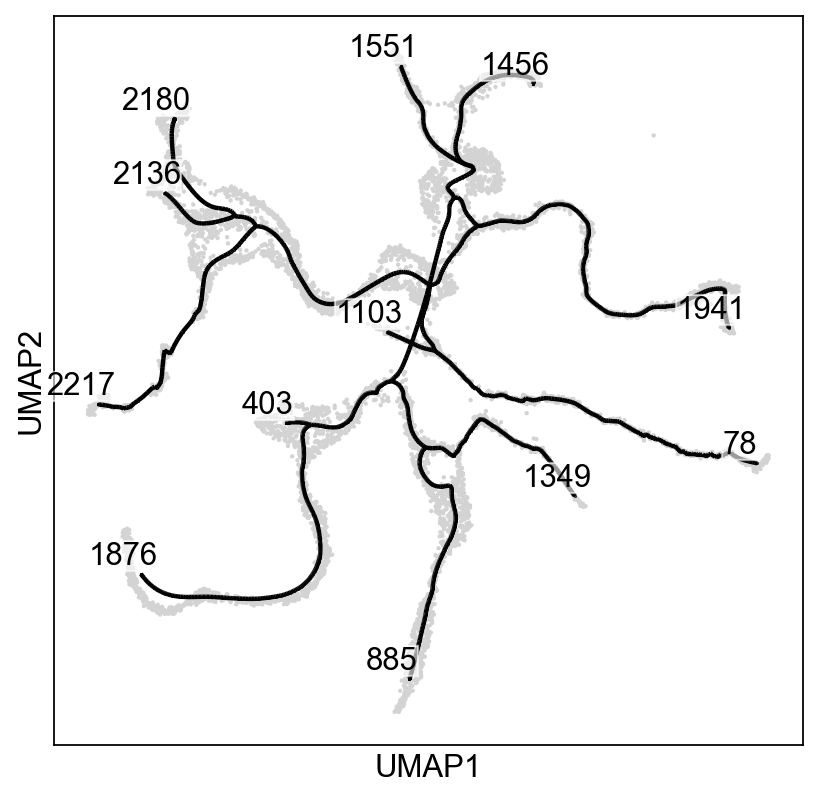

In [33]:
scf.tl.cleanup(adata_merged)
scf.pl.graph(adata_merged,size_nodes=.1,forks=False)

In [40]:
adata.uns["graph"]=adata_merged.uns["graph"]
adata.obsm["X_R"]=adata_merged[adata.obs_names].obsm["X_R"]

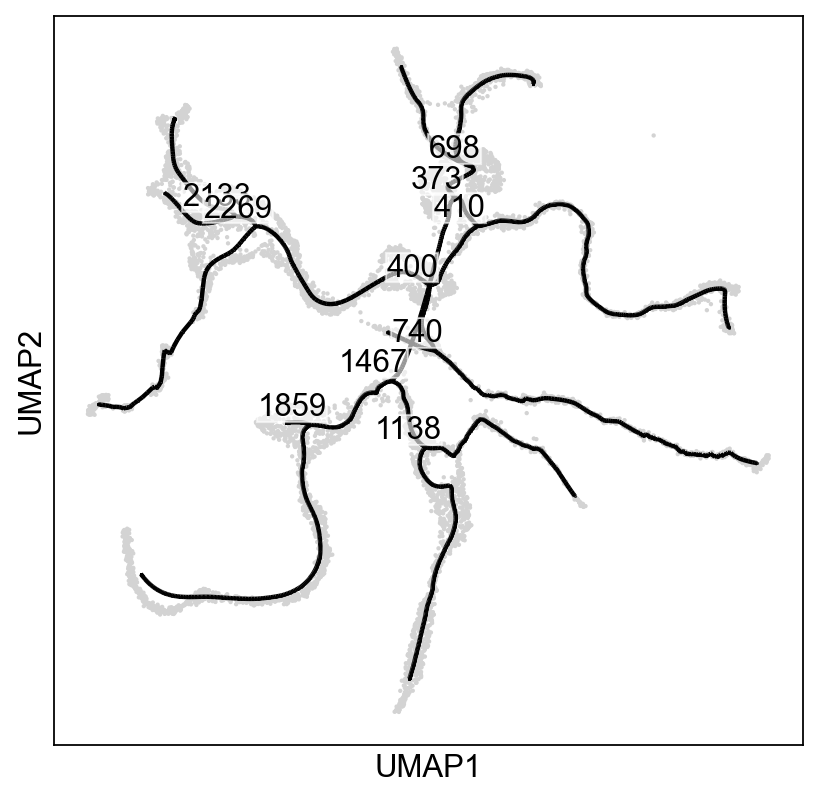

In [41]:
scf.pl.graph(adata,size_nodes=.1,tips=False)

In [42]:
scf.tl.roots(adata,[403,885],meeting=1467)

root selected --> added
    885 is the farthest root.
    .uns['graph']['root'] farthest root selected.
    .uns['graph']['root2'] 2nd root selected.
    .uns['graph']['meeting'] meeting point on the tree.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [43]:
scf.tl.pseudotime(adata)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


projecting cells onto the principal graph
    finished (0:00:10) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


/home/lfaure/scFates/scFates/tools/pseudotime.py:120: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  milestones = pd.Series(index=adata.obs_names)


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


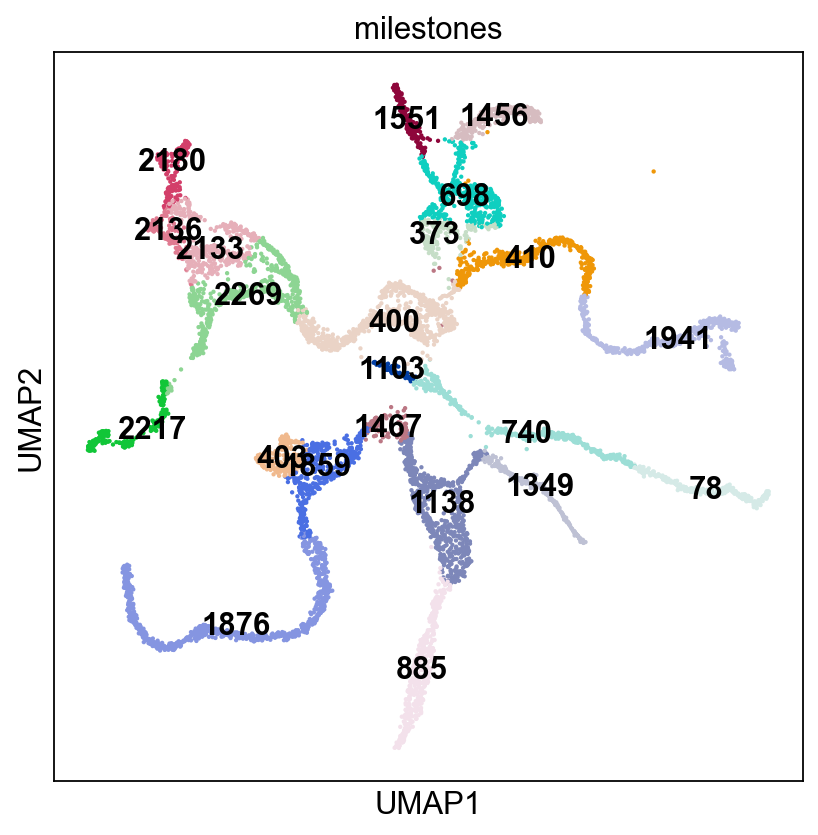

In [44]:
sc.set_figure_params(figsize=(6,6))
sc.pl.umap(adata,color="milestones",legend_loc="on data")

In [45]:
assign={"78":"Sensory 2",
        "1859":"late_NCC1",
        "2133":"mSC<>enFib",
        "2136":"mSC",
        "2217":"nmSC",
        "2269":"nmSC<>mSC",
        "2180":"enFib",
        "400":"SCP-Hub",
        "885":"NCC2",
        "1941":"ChC",
        "740":"Hub-DRG",
        "1456":"GutNeuron",
        "373":"Hub",
        "1876":"Mesenchyme",
        "698":"GutGlia<>GutNeuron",
        "1138":"late_NCC2",
        "410":"Hub-Adrenal<>Gut",
        "1349":"Sensory 1",
        "1551":"GutGlia",
        "1103":"SatGlia",
        "403":"NCC1",
        "1467":"Convergence"}

In [46]:
scf.tl.rename_milestones(adata,[assign[m] for m in adata.obs.milestones.cat.categories])

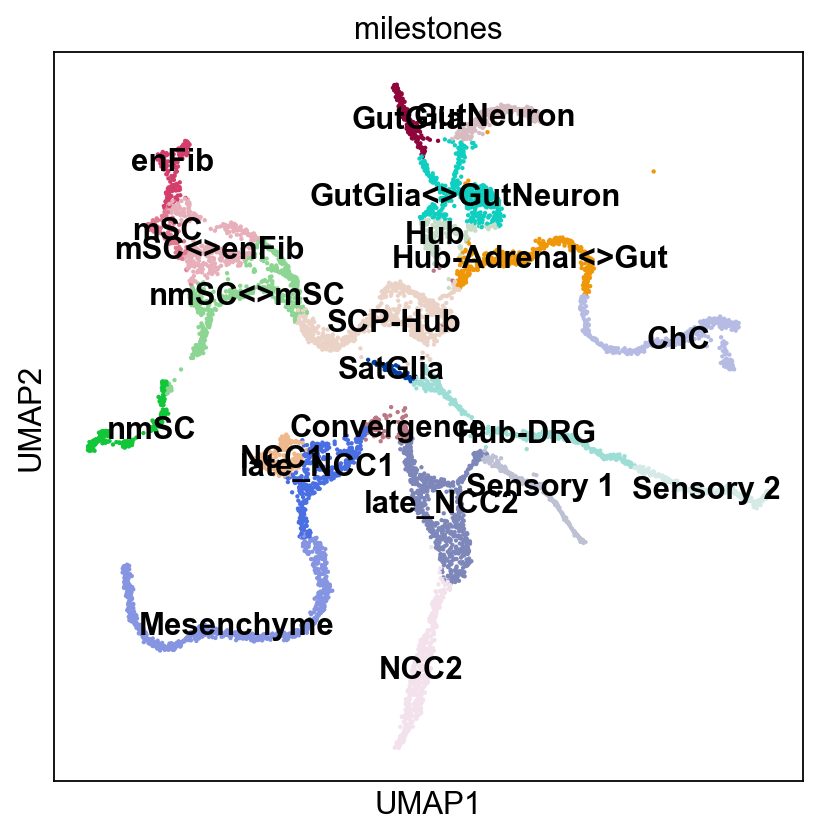

In [47]:
sc.set_figure_params(figsize=(6,6))
sc.pl.umap(adata,color="milestones",legend_loc="on data")

In [48]:
adata.write("data/adata_tree.h5ad")

In [ ]:
adata_p=sc.read("data/adata_processed.h5ad")

In [49]:
adata

AnnData object with n_obs × n_vars = 7868 × 21676
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 't', 'seg', 'edge', 'milestones'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'devtime_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'paga', 'umap', 'graph', 'ppt', 'pseudotime_list', 'milestones_colors'
    obsm: 'X_diff', 'X_pca', 'X_umap', 'X_R'
    layers: 'palantir_imp', 'scaled'
    obsp: 'connectivities', 'distances'